# Segment size considerations - Multi segment approximation setting

Does the great approximation behaviour of shifted Chebyshev carry over to the multi-segment scenario?
If not, why not? Do we need to adapt our code? 
What does further shifting a shifted basis actually mean?
How do the other Bases perform?
Lets find out.


Version 1.0
Date: 2023-09-25
Current version: hannes.waclawek@fh-salzburg.ac.at

# Findings

## Sensitivity to x-data range
Fitting with Shifted Chebyshev Base is extremely sensitive to the x-data range of individual segments.
This is expected, since it only is a basis for polynomials over $\mathbb{R}$ in the range $[0, 1]$.
The same is true for Chebyshev basis and range $[-1, 1]$.
In order to have comparable and functioning ranges, we therefore scale input data to segment sizes:

 - Power Basis: 2.0 (Shift center to 1.0, equals range $[-1, 1]$)
- Chebyshev Basis: 2.0 (Shift center to 1.0, equals range $[-1, 1]$)
- Shifted Chebyshev Basis: 1.0  (Shift center to 0.0, equals range $[0, 1]$)

In [49]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
learning_rate = 0.1
shift_polynomial_centers = 'mean' # Power and Chebyshev Basis
shift_polynomial_centers_sc = 'boundary' # Shifted Chebyshev Basis
ck = 2
degree = 5

colors = list(mcolors.TABLEAU_COLORS.keys())

Text(0.5, 1.0, 'Scaled to range [0, 1] for 1 polynomial segment')

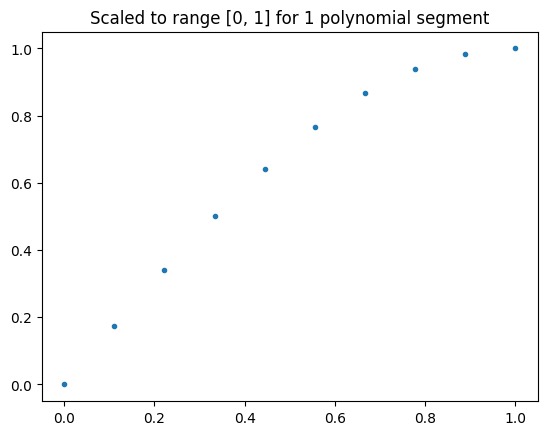

In [52]:
xs = np.linspace(0, 0.5*np.pi, 10)
ys = np.array(np.sin(xs))
xs = sampledata.rescale_input_data(xs, 1)
plt.plot(xs, ys, '.')
plt.title('Scaled to range [0, 1] for 1 polynomial segment')

Text(0.5, 1.0, 'Scaled to range [0, 1.8] for 2 polynomial segments')

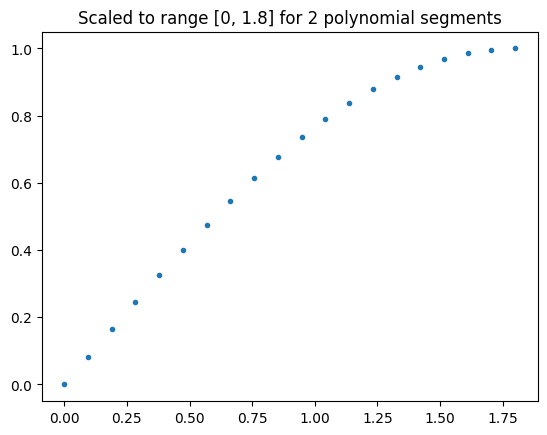

In [53]:
# The data set to approximate with x and y samples
xs2_ori = np.linspace(0, 0.5*np.pi, 20)
ys2 = np.sin(xs2_ori)
#plt.plot(xs2_ori, ys2, '.')
xs2 = sampledata.rescale_input_data(xs2_ori, 1.8)
plt.plot(xs2, ys2, '.')
plt.title('Scaled to range [0, 1.8] for 2 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 2] for 2 polynomial segments')

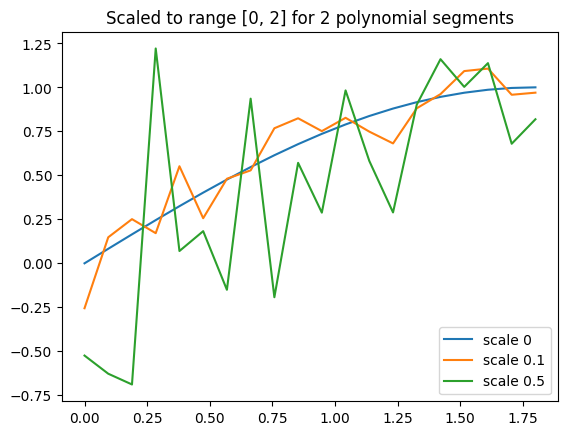

In [54]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ys2gauss_scales = [0.0, 0.1, 0.5]
ys2gauss = [ys2 + np.random.normal(scale=s, size=len(ys2)) for s in ys2gauss_scales]
ysgauss = [ys + np.random.normal(scale=s, size=len(ys)) for s in ys2gauss_scales]

for i, ysn in enumerate(ys2gauss):
    plt.plot(xs2, ysn, '-', label='scale %.2g' % ys2gauss_scales[i])
plt.legend(loc="best")
plt.title('Scaled to range [0, 2] for 2 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 4] for 4 polynomial segments')

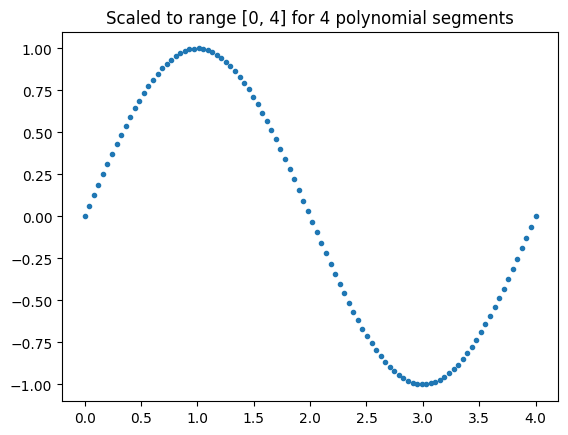

In [55]:
xsin = np.linspace(0, 2*np.pi, 100)
ysin = np.sin(xsin)
xsin = sampledata.rescale_input_data(xsin, 4)

plt.plot(xsin, ysin, '.')
plt.title('Scaled to range [0, 4] for 4 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 10] for 10 polynomial segments')

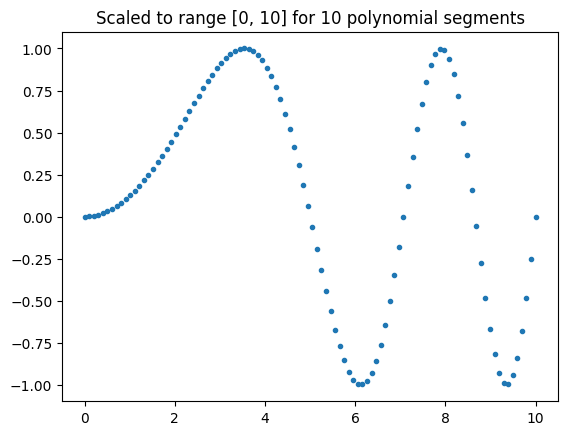

In [56]:
xsinvar = np.linspace(0, 1, 100)
ysinvar = np.sin(xsinvar**2 * 4 * np.pi)
xsinvar = sampledata.rescale_input_data(xsinvar, 10)

plt.plot(xsinvar, ysinvar, '.')
plt.title('Scaled to range [0, 10] for 10 polynomial segments')

## Sensitivity to segment x data range

In [47]:
lambd = 0.5
epochs = 500

In [68]:
spline_shifted_chebyshev_single = model.Spline(polydegree=degree, polynum=1, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_single.fit(xs, ys, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0)

<tf.Tensor: shape=(), dtype=float64, numpy=2.328113352480814e-11>

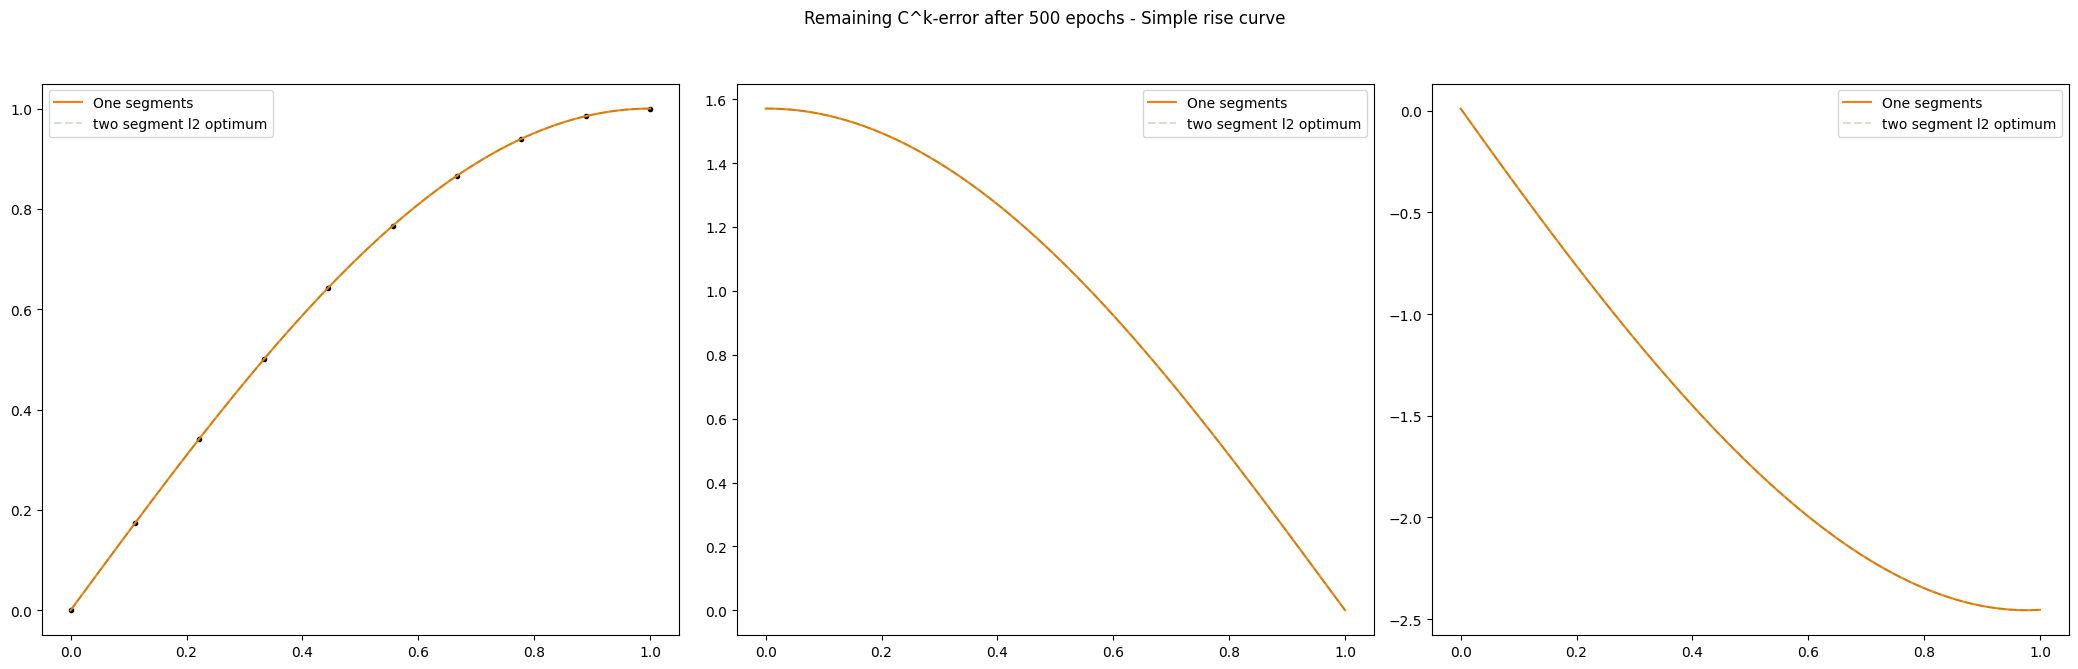

In [69]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Simple rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_single, ax=axes[i], label=f'One segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_single, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

The single segment result basically matches the optimum for the segment.

In [53]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.00018806016066889213>

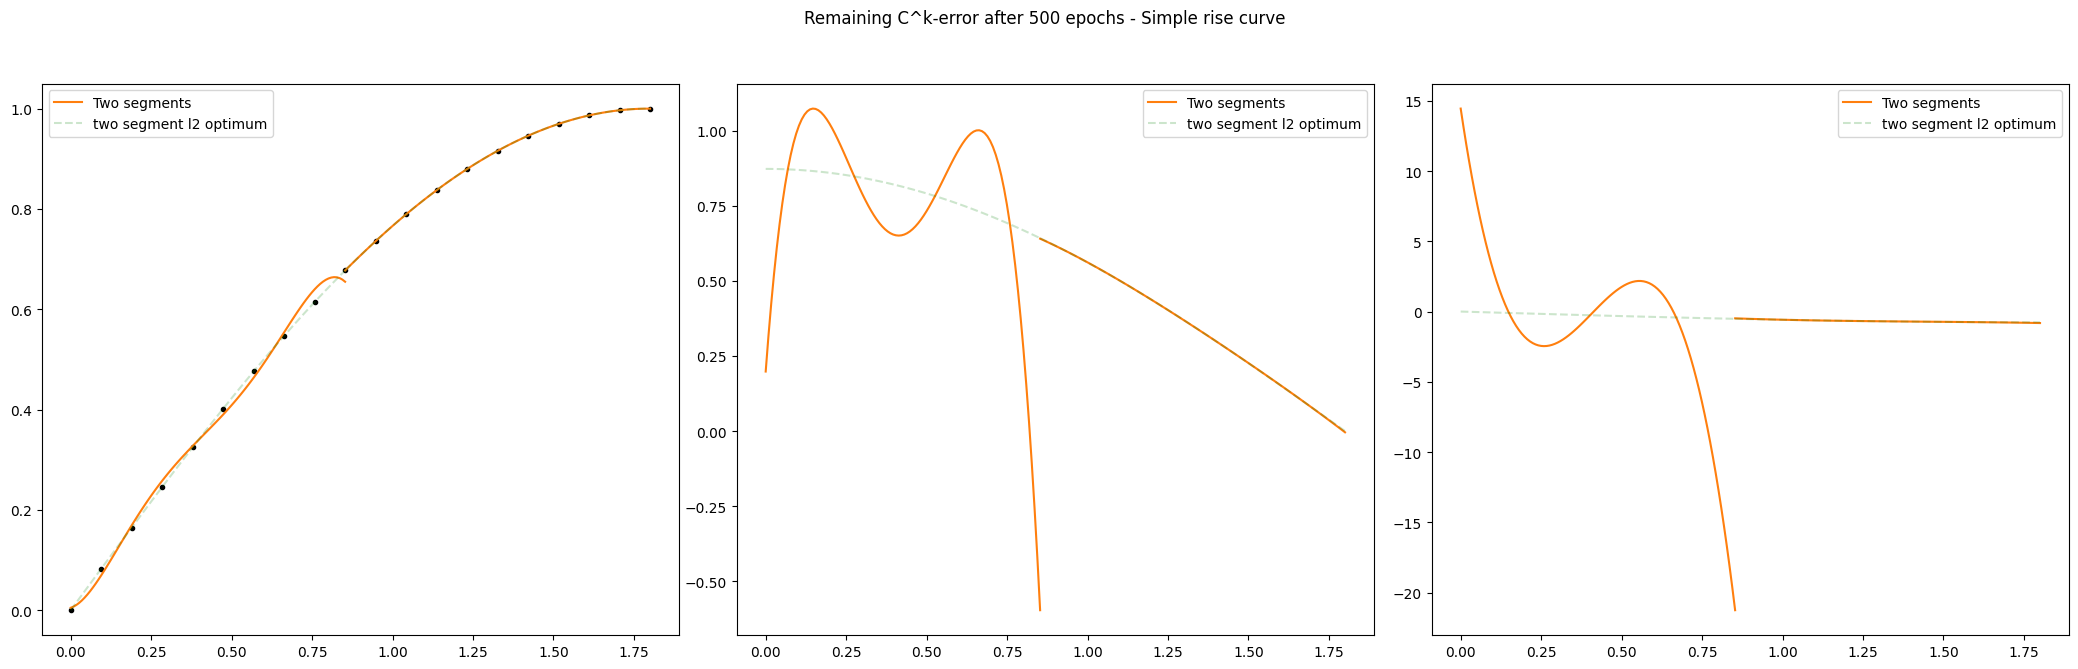

In [54]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Simple rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')


### Interpretation

The two segment result shows interesting behaviour: The first segment is a mess, while the second segment is perfect.
Looking at the segment ranges after the internal splitting routine:
 - Segment 1: [0, 0.85]
 - Segment 2: [0.85, 1.8]

So, considering shifting of x-values, the second segment is closer to the full Shifted Chebyshev Basis range of [0, 1].
Lets rescale input data and try again:

In [58]:
xs2 = sampledata.rescale_input_data(xs2_ori, 1.9)

In [56]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=3.7608241324907184e-05>

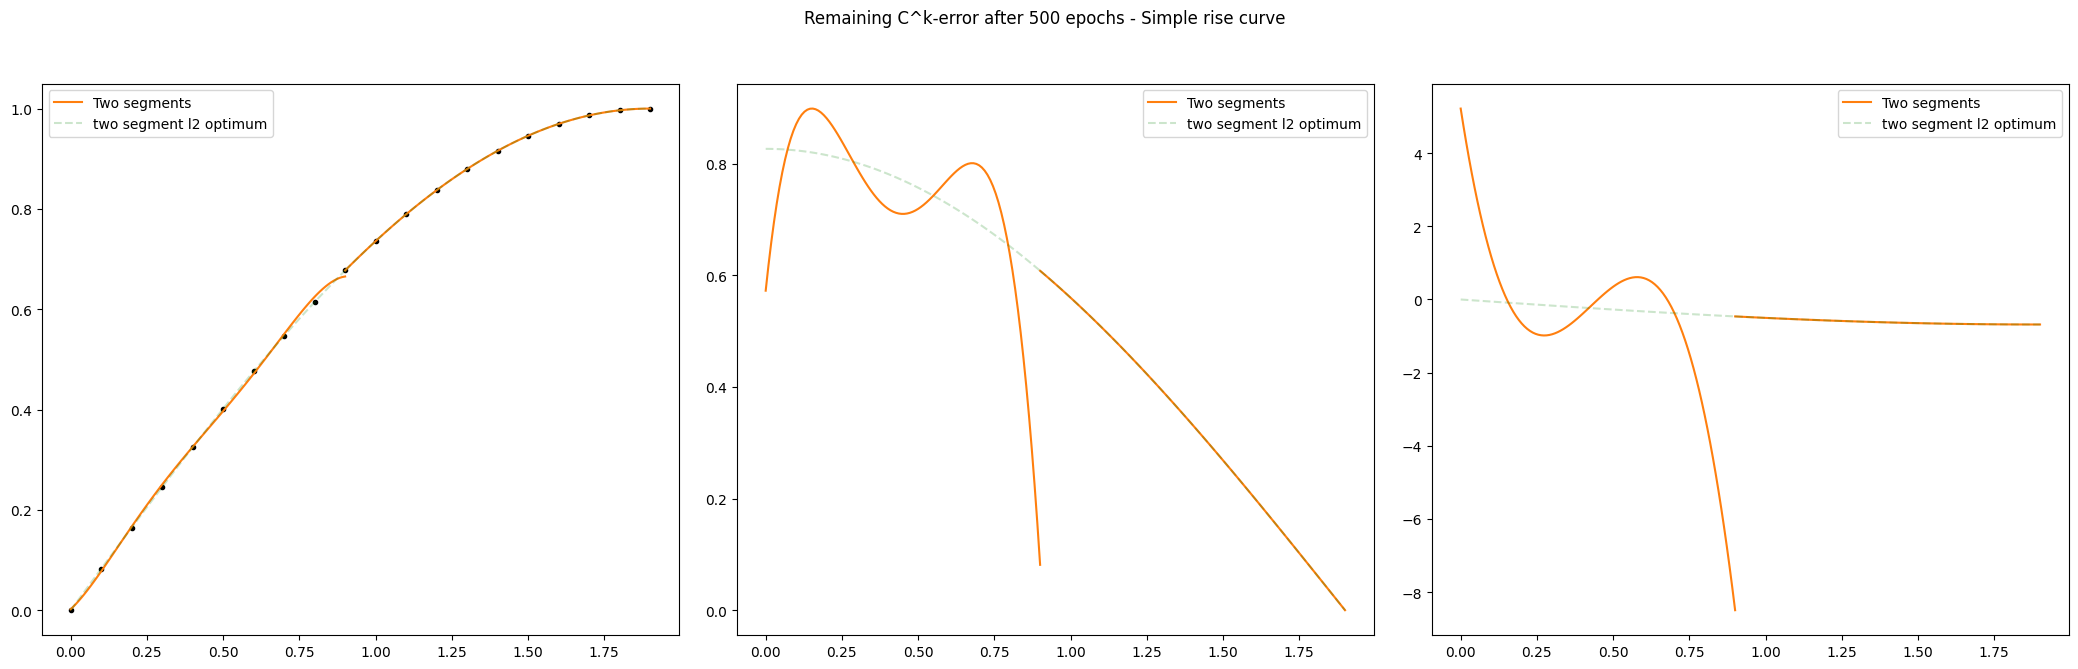

In [57]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Simple rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

## Interpretation

Better, but not perfect.
What has changed?
 - Segment 1: [0, 0.85] --> [0, 0.9]
 - Segment 2: [0.85, 1.8] --> [0.9, 1.9]

In [74]:
xs2 = sampledata.rescale_input_data(xs2_ori, 1.98)

In [75]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=1.8338928108460904e-09>

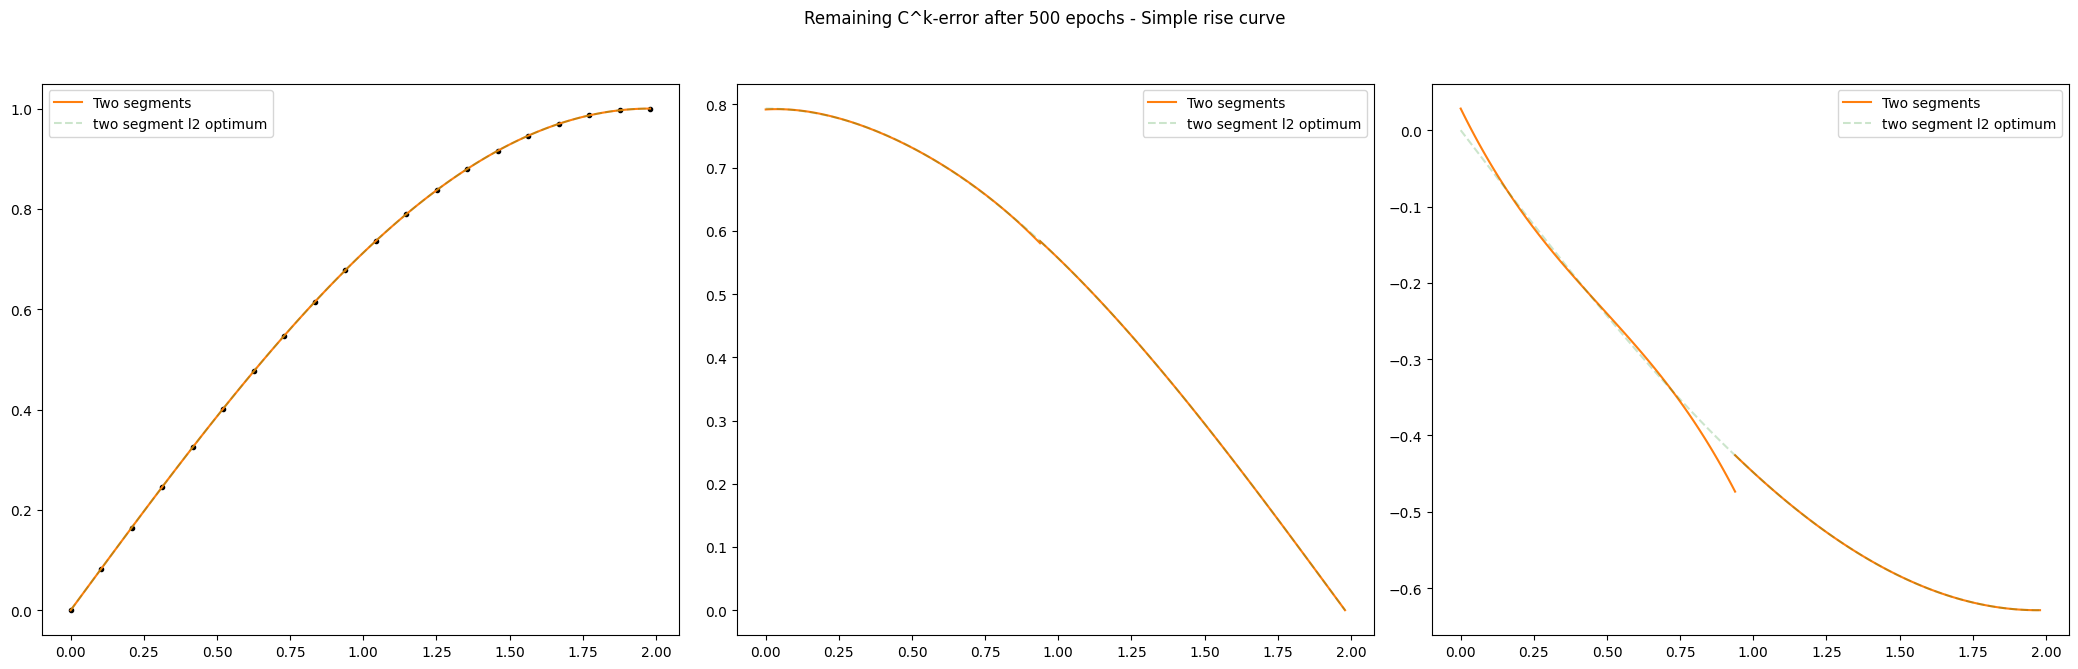

In [76]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Simple rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

Now we are at:
 - Segment 1: [0, 0.9] --> [0, 0.94]
 - Segment 2: [0.85, 1.8] --> [0.93, 1.98]

In [98]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2)

In [79]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=3.573231140075559e-12>

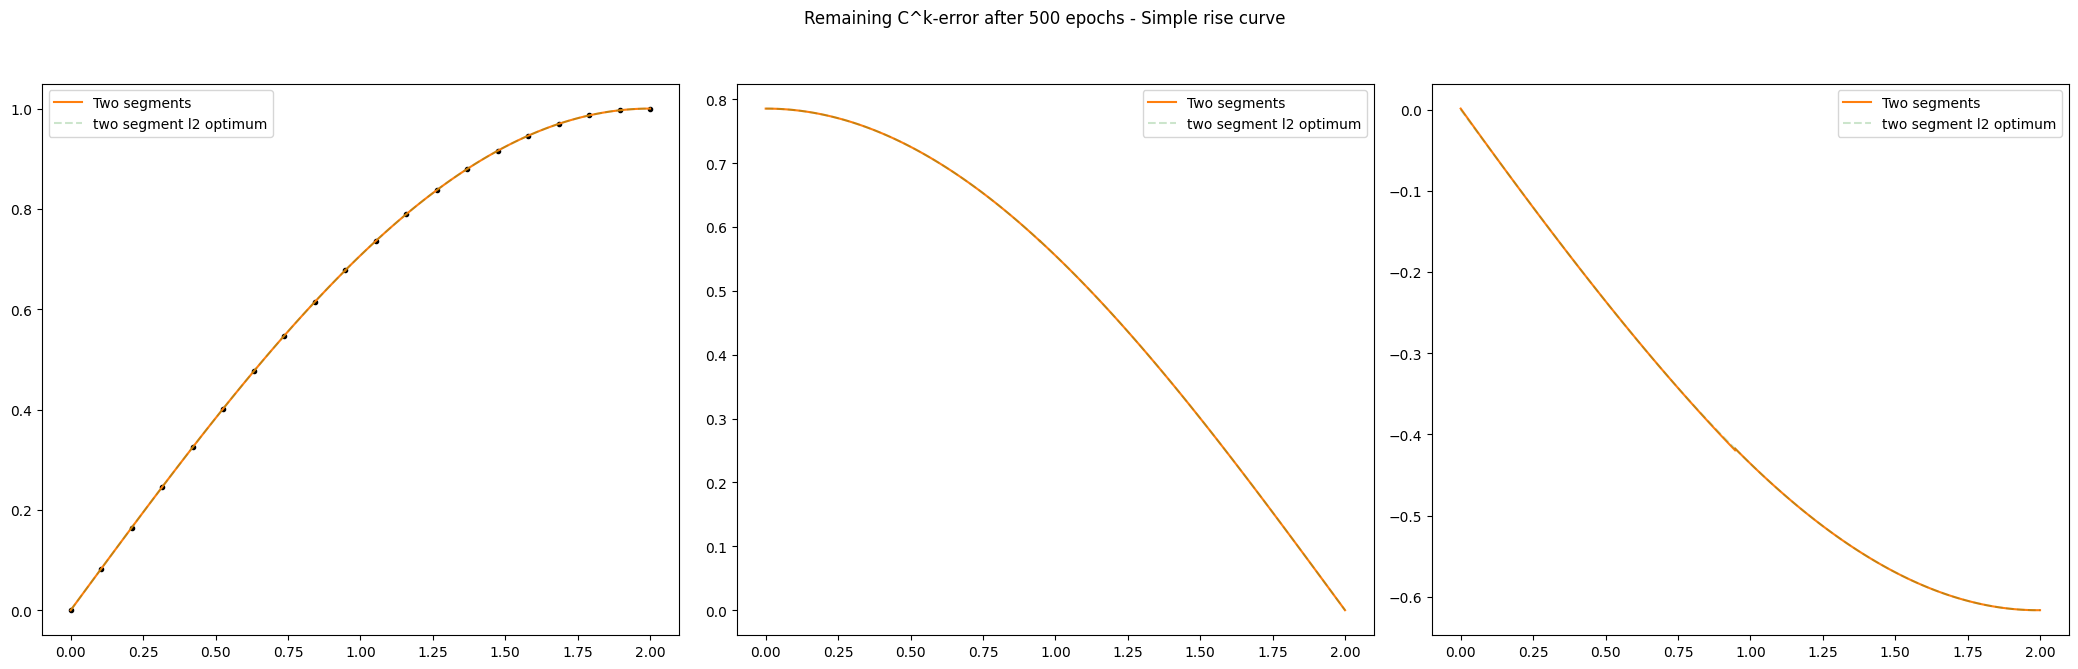

In [80]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Simple rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

Now both segments are perfect. Ranges:
 - Segment 1: [0, 0.94] --> [0, 0.95]
 - Segment 2: [0.85, 1.8] --> [0.95, 2]

In [97]:
polynum = 2

In [99]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.27944630910582624>

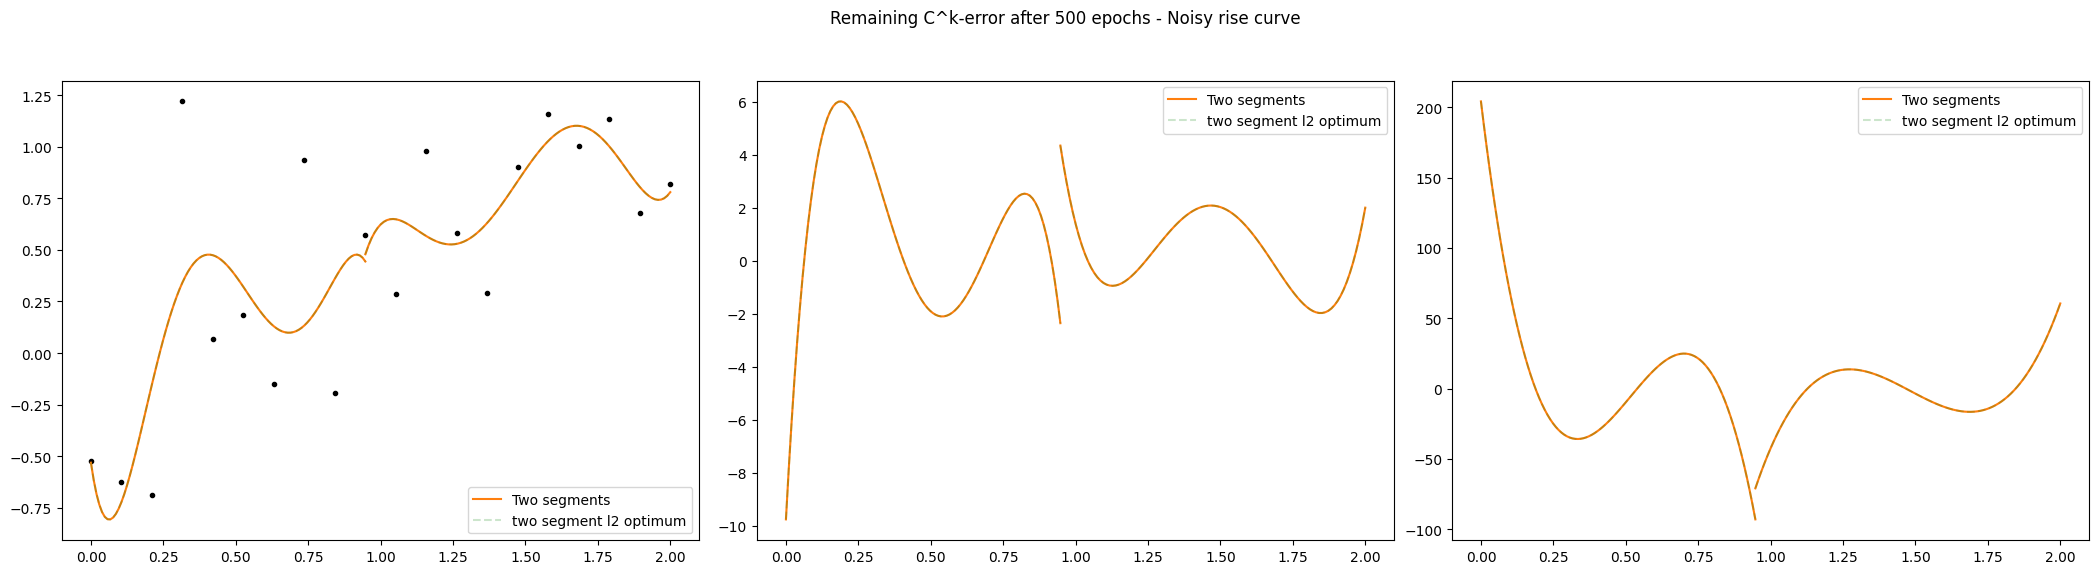

In [100]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

## Interpretation

Segment 1 is still off! Can we fix it by adjusting segment size again?

In [101]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2.1)

In [102]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.27944630910505974>

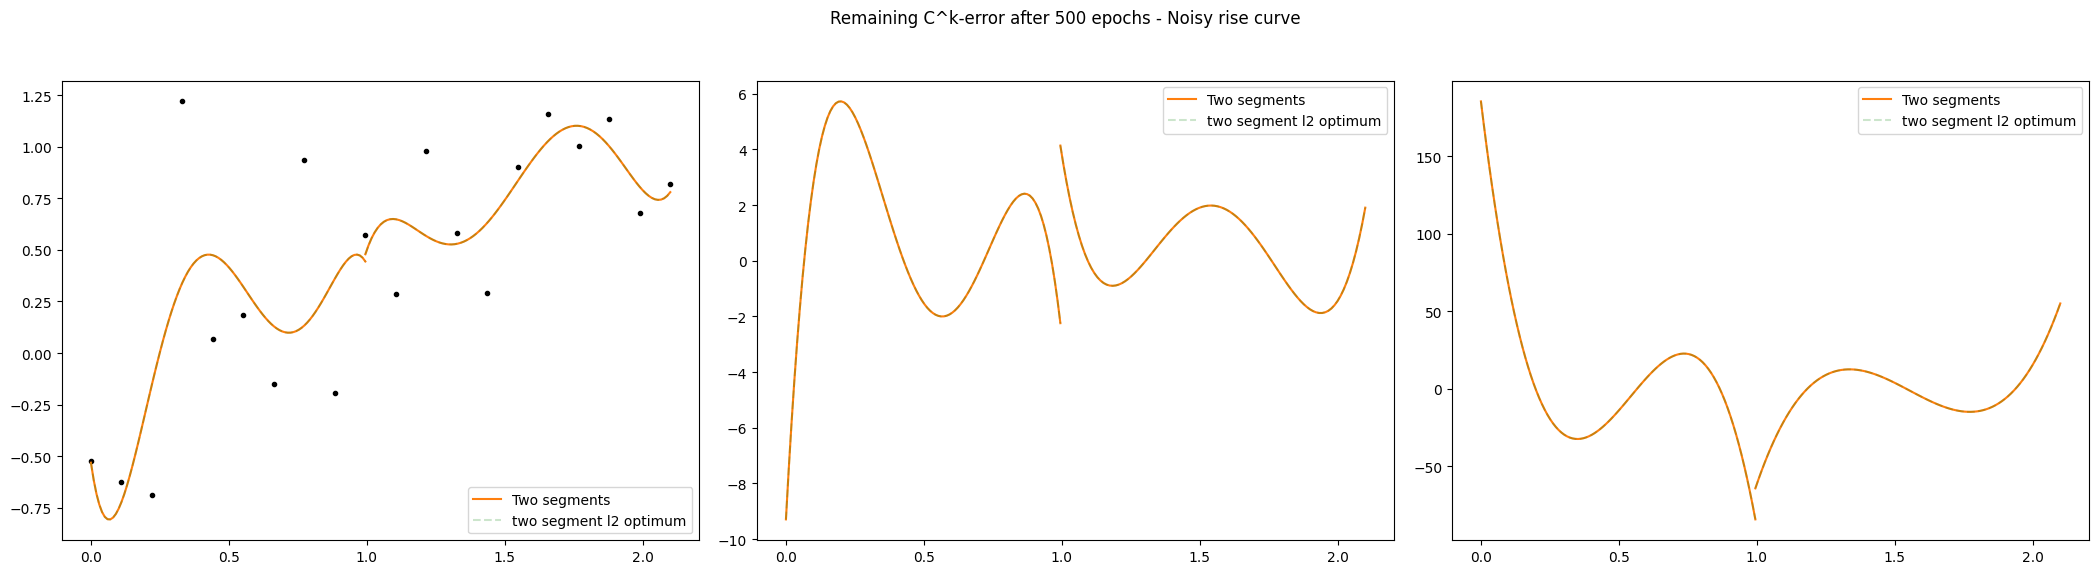

In [103]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

## Interpretation

Yes we can! Segment size is now:

 - Segment 1: [0, 0.95] --> [0, 0.99]
 - Segment 2: [0.95, 2] --> [0.99, 2.1]

The second segment now is already exceeding the range of [0, 1] spanned by the Shifted Chebyshev Basis.
How far can we go until the result gets messed up?

In [107]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2.2)

In [108]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2794781260281609>

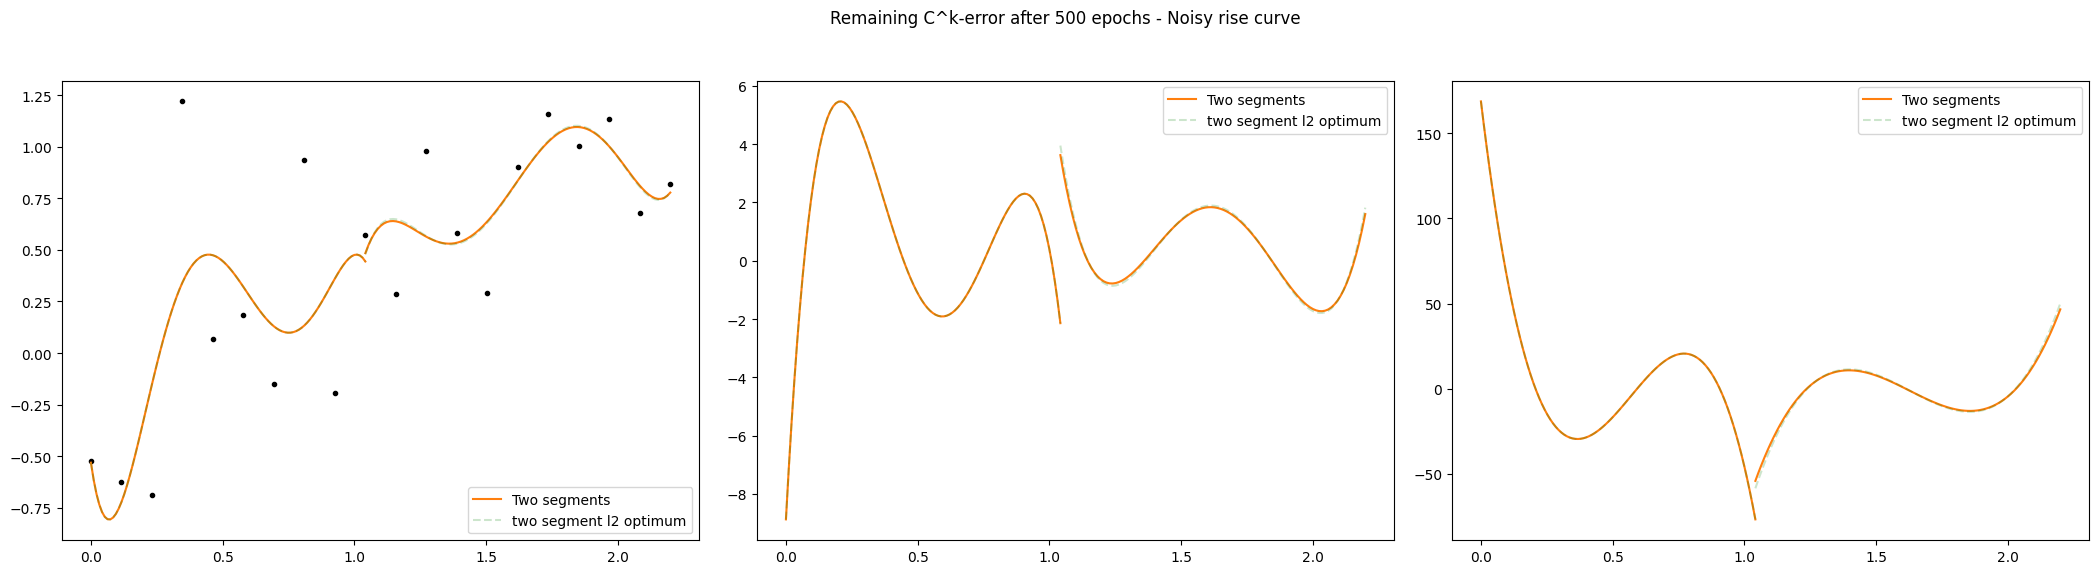

In [109]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

We are now at 
- Segment 1: [0, 0.99] --> [0, 1.04]
- Segment 2: [0.99, 2.1] --> [1.04, 2.2]

and see the second segment beginning to deviate from the optimum.

In [116]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2.4)

In [117]:
spline_shifted_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_shifted_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2849396804498632>

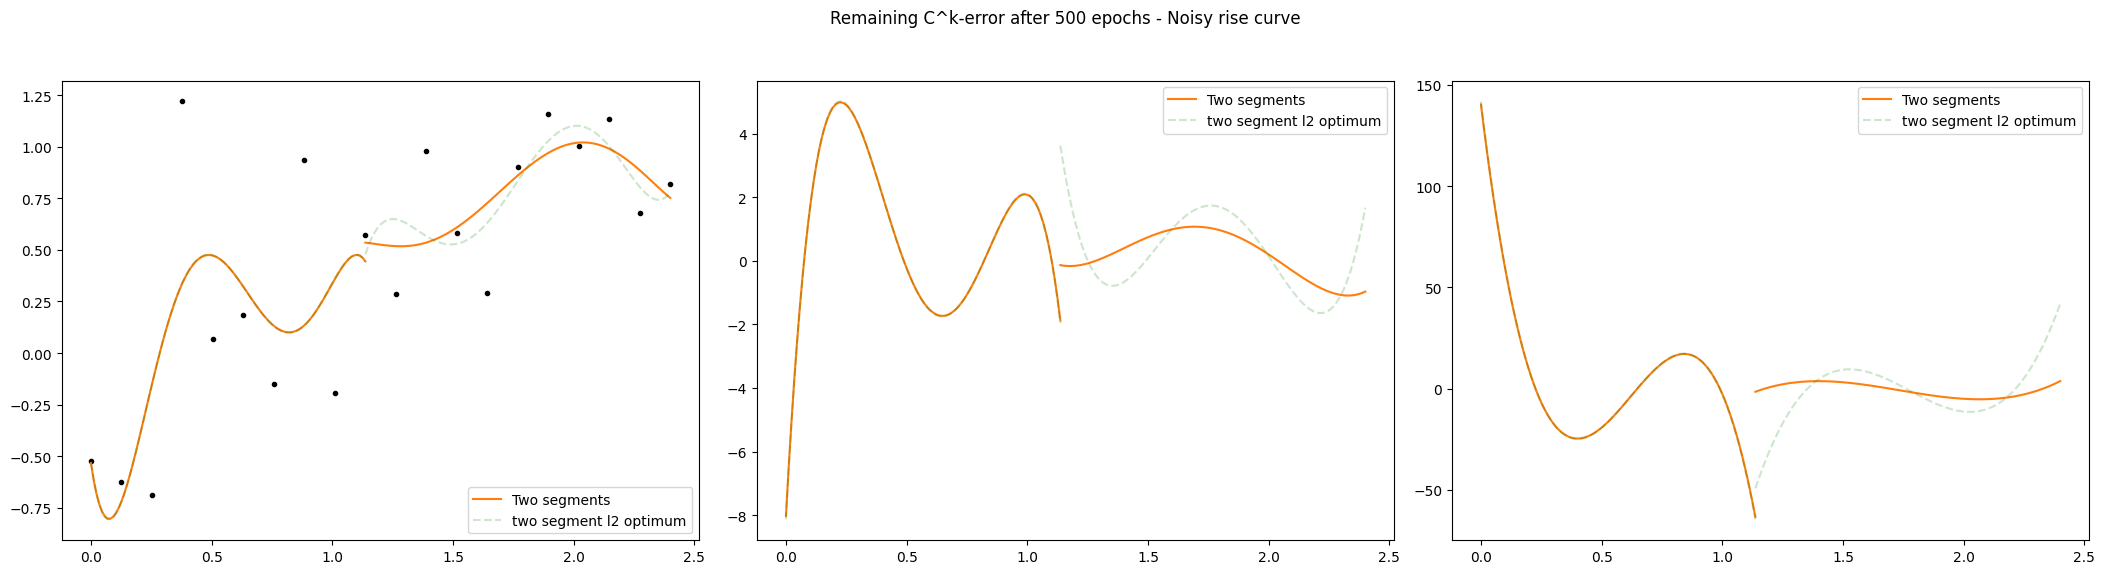

In [118]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_shifted_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_shifted_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

And off we go! Segment sizes are now:
- Segment 1: [0, 1.04] --> [0, 1.14]
- Segment 2: [1.04, 2.2] --> [1.14, 2.4]

**Summary:**
Fitting with Shifted Chebyshev Base is extremely sensitive to the x-data range of individual segments.
**In our experiments, a segment always must span a float range of minimum 1.0 to a maximum of ~1.1 to receive optimum results.**

## Sensitivity to segment x data range - Chebyshev Basis
Lets check if the Chebyshev Basis experiences similar behaviour for its x data segment range than its Shifted Chebyshev version.
The Basis spans the interval [-1, 1]. Since we shift polynomials to the segment mean,
the maximum / optimum interval for Chebyshev basis should be [0, 2].

In [131]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2.1)

In [132]:
spline_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
spline_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.30501135527804274>

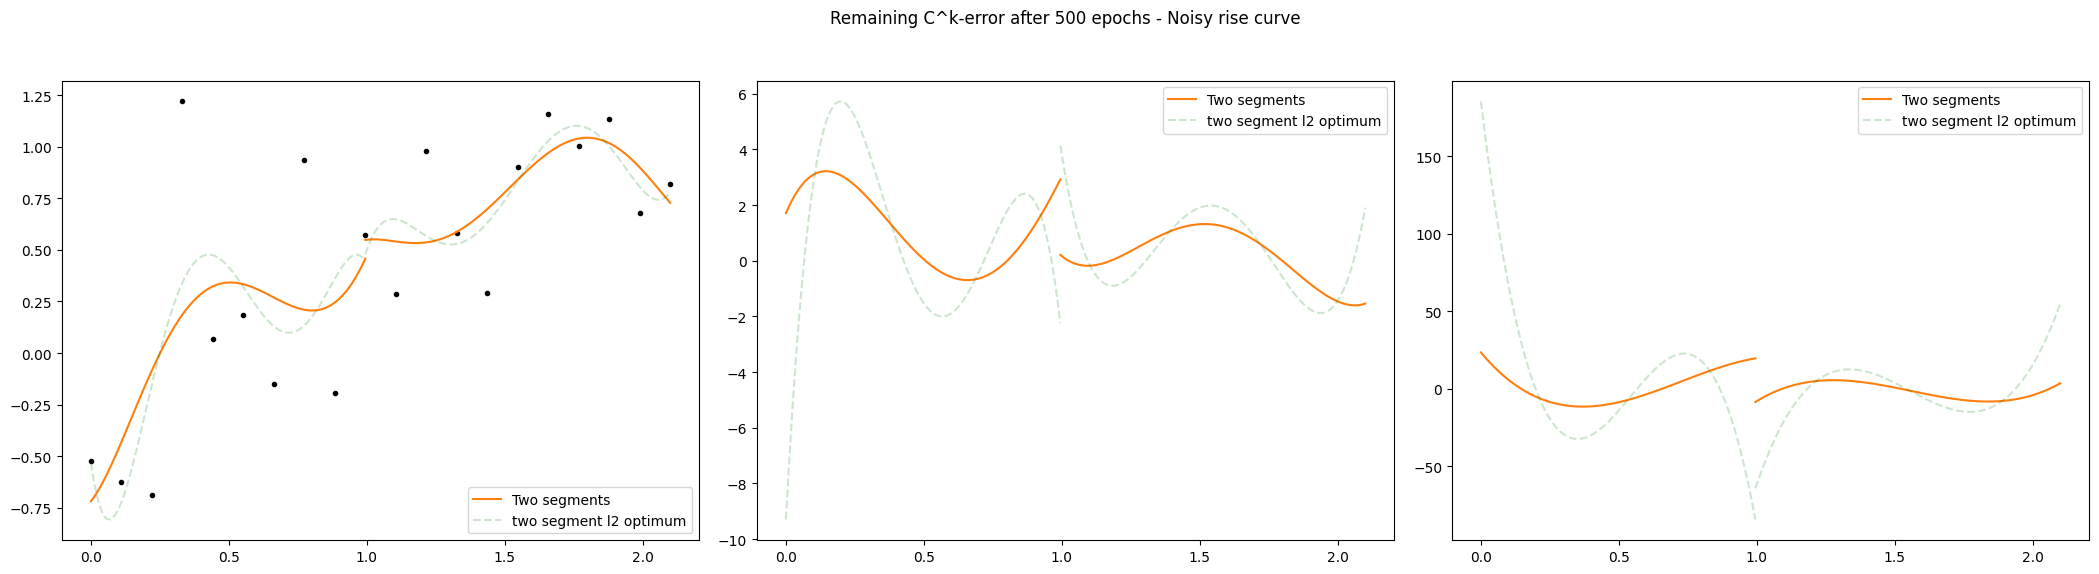

In [133]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

This is the kind of performance we saw when looking at Chebyshev Basis in our "01_chebyshev_baseline_experiments.ipynb" notebook.

- Segment 1: [0, 0.99]
- Segment 2: [0.99, 2.1]

Can we increase performance by raising the x-data segment range to the assumed optimum described above?
The Basis spans the interval [-1, 1]. Since we shift polynomials to the segment mean,
the maximum / optimum interval for Chebyshev basis should be [0, 2].
So, if we raise our input data to span [0, 4], by splitting into two segments, we should receive that optimum.

In [137]:
xs2 = sampledata.rescale_input_data(xs2_ori, 4)

In [138]:
spline_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
spline_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2794463091050608>

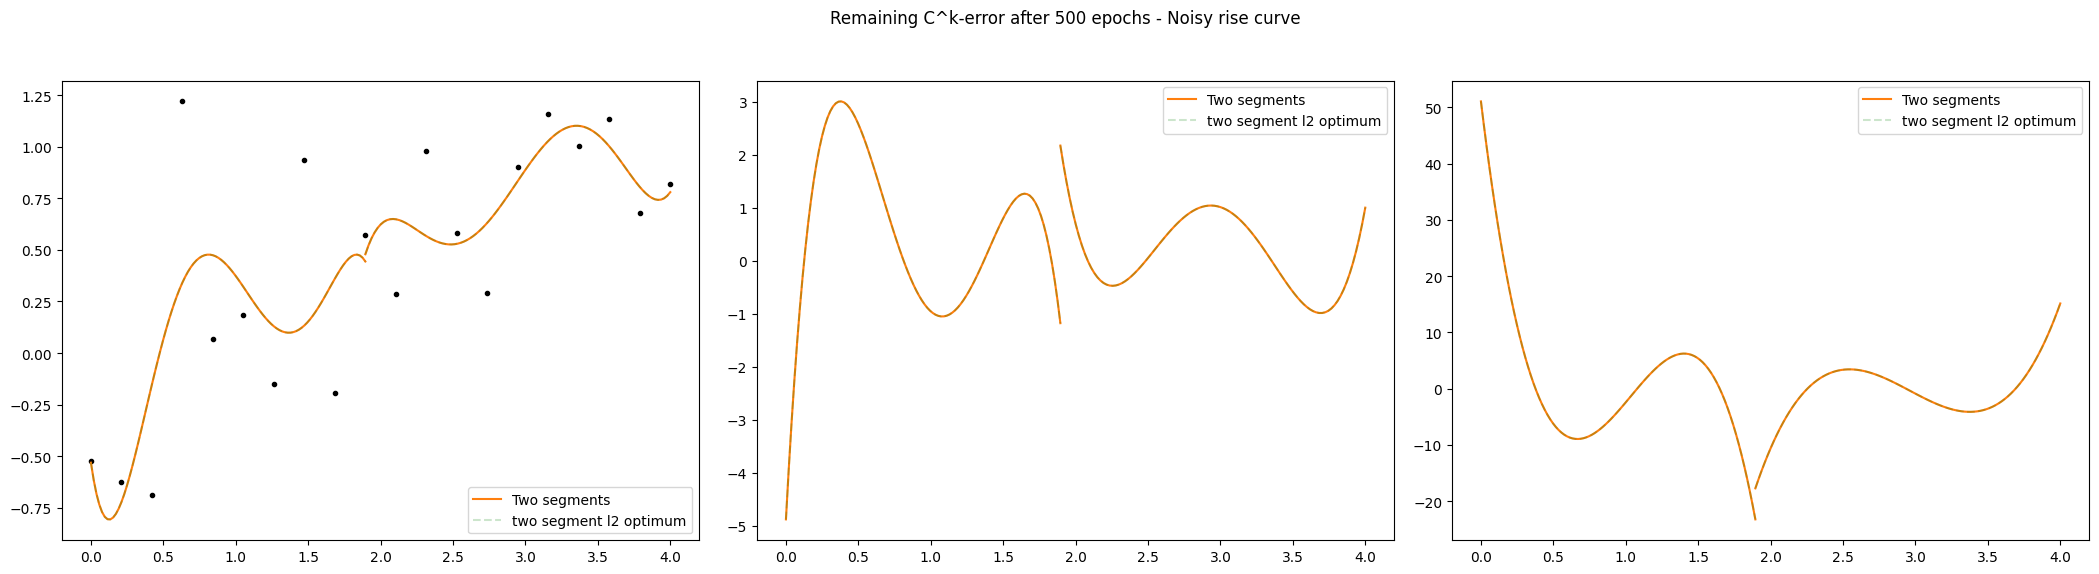

In [139]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

Indeed we receive the same perfect result and loss as with Shifted Chebyshev Basis.

- Segment 1: [0, 1.9]
- Segment 2: [1.9, 4]

How sensitive is the Chebyshev Basis to deviating from that segment range?

In [140]:
xs2 = sampledata.rescale_input_data(xs2_ori, 3)

In [141]:
spline_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
spline_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2795031669655484>

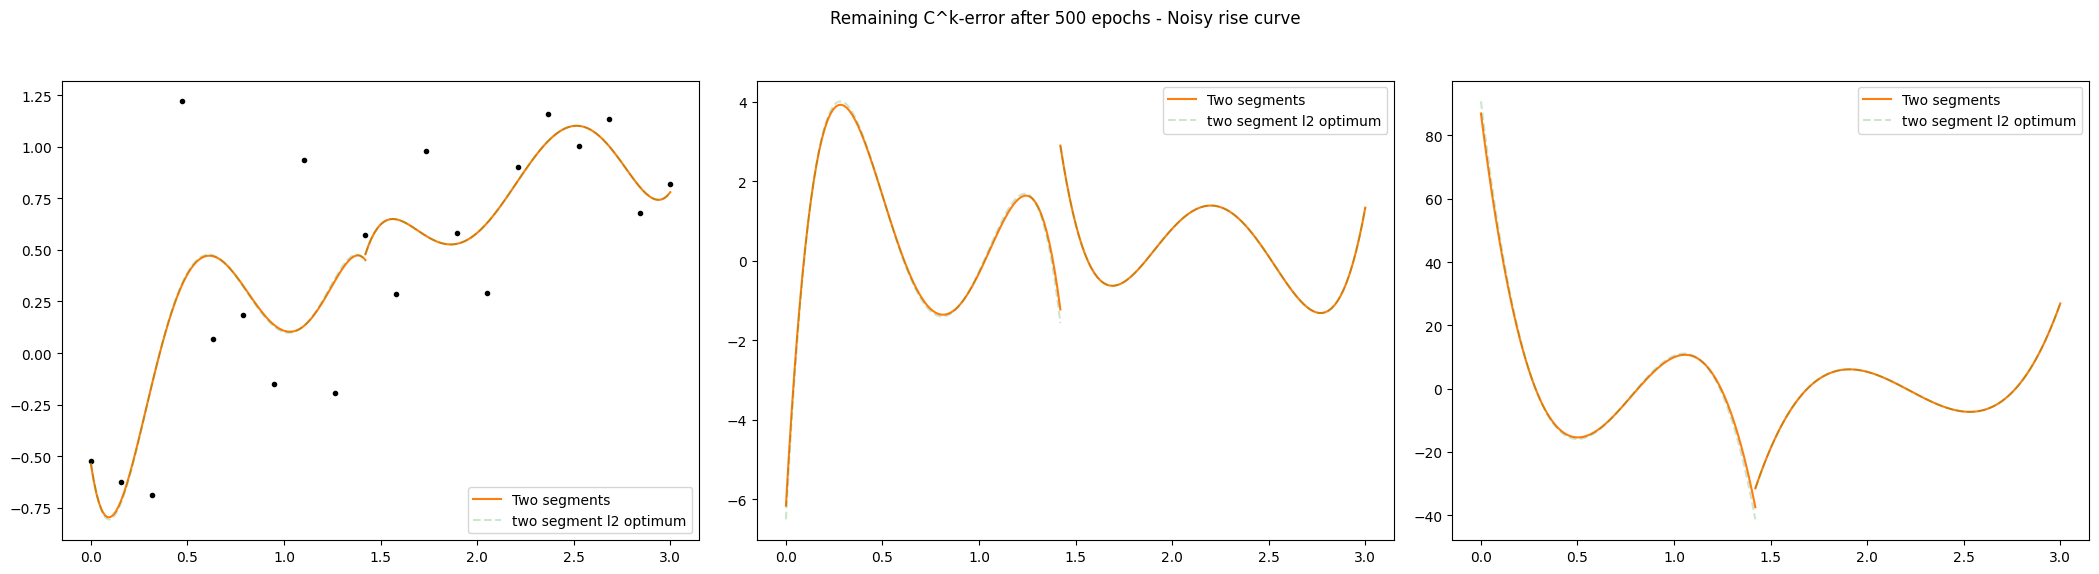

In [142]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

Slightly beginning to deviate, but not significantly.

- Segment 1: [0, 1.9] --> [0, 1.42]
- Segment 2: [1.9, 4] --> [1.42, 3]

In [144]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2.5)

In [145]:
spline_chebyshev_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
spline_chebyshev_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2885258122814121>

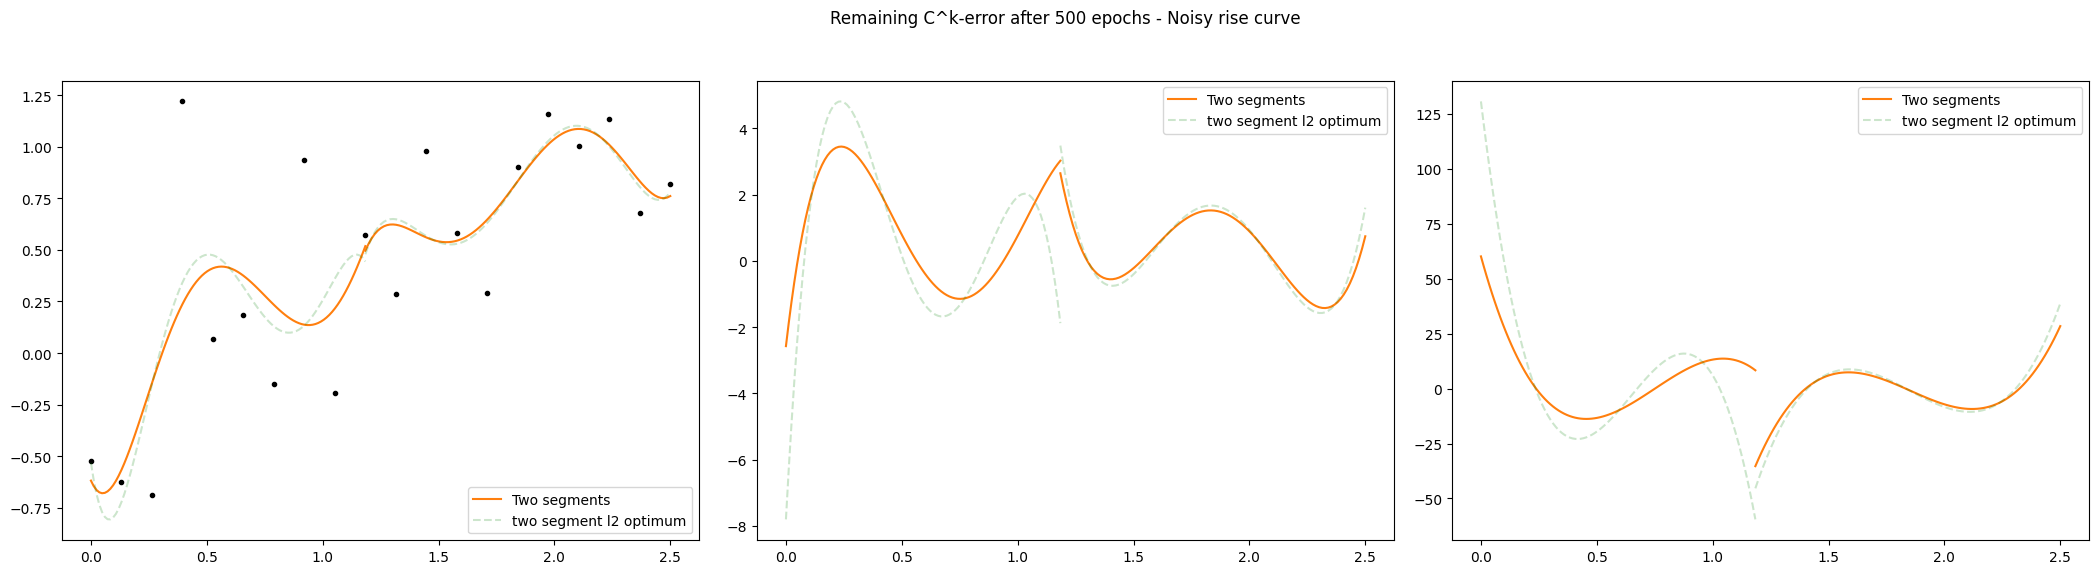

In [146]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

Now we see significant deviations in both segments.

- Segment 1: [0, 1.42] --> [0, 1.18]
- Segment 2: [1.42, 3] --> [1.18, 2.5]

## Sensitivity to segment x data range - Power Basis
Does the Power Basis experience similar behaviour?

In [156]:
xs2 = sampledata.rescale_input_data(xs2_ori, 2.1)

In [157]:
spline_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='power', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.95, nesterov=True)
spline_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.33336898468968684>

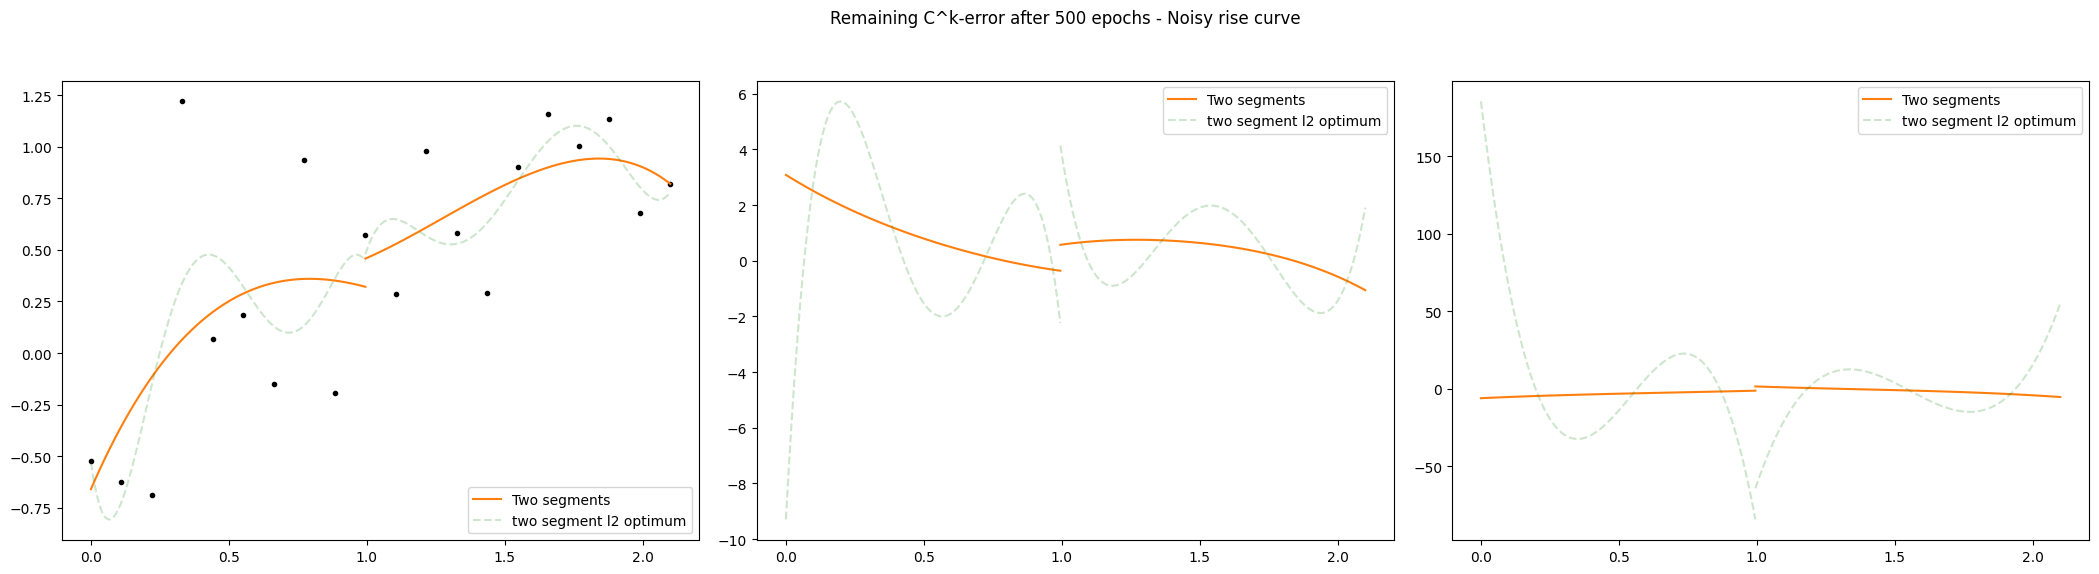

In [158]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

This is the kind of performance we saw when looking at Power Basis in our "01_chebyshev_baseline_experiments.ipynb" notebook.

- Segment 1: [0, 0.99]
- Segment 2: [0.99, 2.1]

In [159]:
xs2 = sampledata.rescale_input_data(xs2_ori, 4)

In [160]:
spline_double = model.Spline(polydegree=degree, polynum=2, ck=ck, basis='power', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.95, nesterov=True)
spline_double.fit(xs2, ys2gauss[2], optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, overlap_segments=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.30117817314156997>

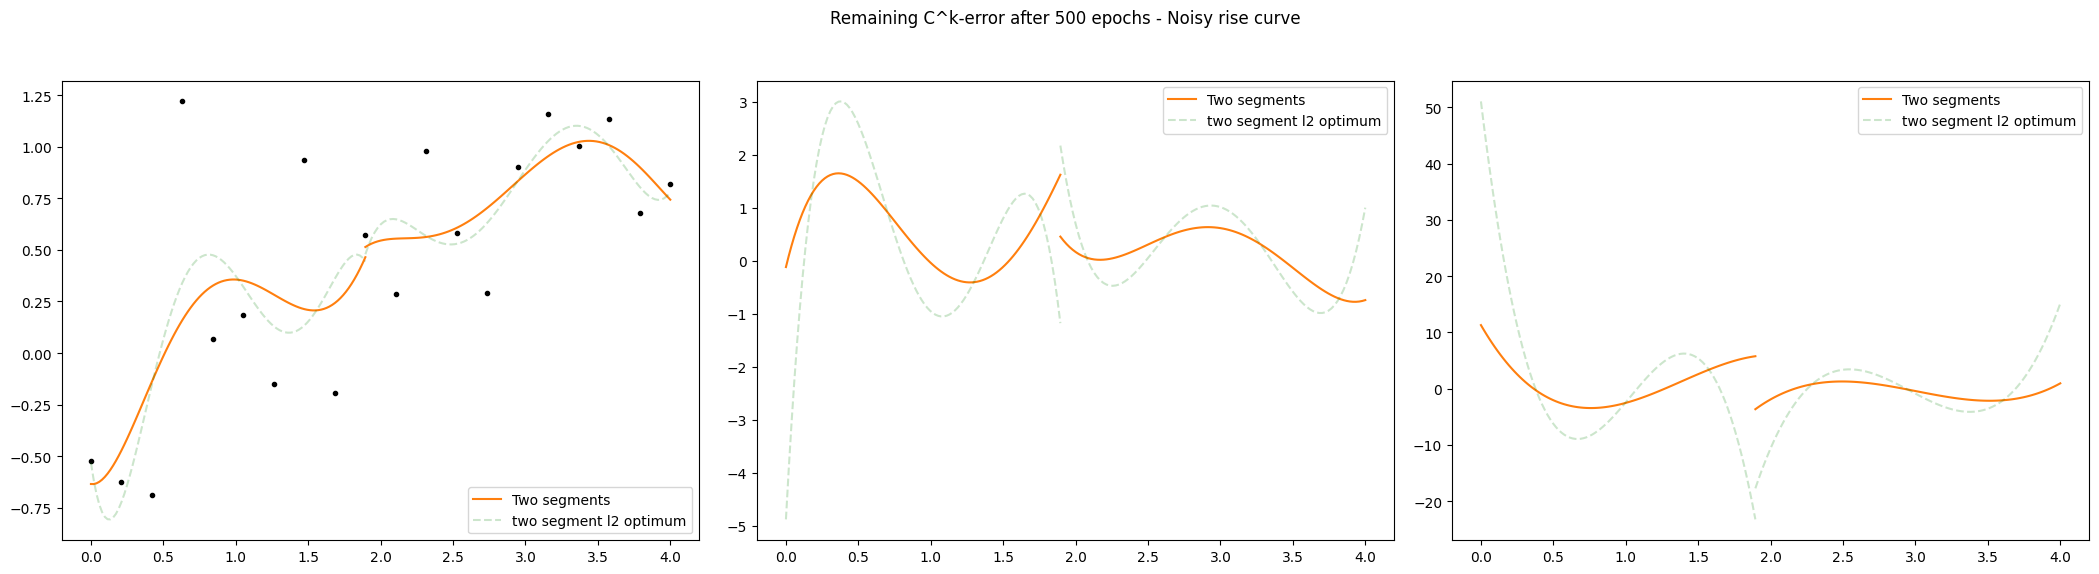

In [161]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Noisy rise curve')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_double, ax=axes[i], label=f'Two segments', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_double, ax=axes[i], deriv=i, color='g', label='two segment l2 optimum')
    axes[i].legend(loc='best')

### Interpretation

The result is slightly better, but not as significant as with Chebyshev Basis.

## Retrieve optimal segment size for approximation target all bases

In [185]:
epochs = 500
params = np.arange(0.5, 3.5, 0.05)
no_segments = 1
factor_approximation_quality = 1
factor_ck_pressure = 0

In [186]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_simple_rise = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_simple_rise = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_simple_rise = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ysgauss[1], 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_noisy_rise_1 = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ysgauss[1], 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_noisy_rise_1 = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ysgauss[1], 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_noisy_rise_1 = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ysgauss[2], 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_noisy_rise_2 = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ysgauss[2], 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_noisy_rise_2 = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ysgauss[2], 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'segment_size',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_noisy_rise_2 = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

In [195]:
# get total loss values of every entry
losses_simple_rise = [0.0] * len(results_simple_rise)
losses_chebyshev_simple_rise = [0.0] * len(results_simple_rise)
losses_shifted_chebyshev_simple_rise  = [0.0] * len(results_simple_rise)
losses_noisy_rise_1 = [0.0] * len(results_simple_rise)
losses_chebyshev_noisy_rise_1 = [0.0] * len(results_simple_rise)
losses_shifted_chebyshev_noisy_rise_1  = [0.0] * len(results_simple_rise)
losses_noisy_rise_2 = [0.0] * len(results_simple_rise)
losses_chebyshev_noisy_rise_2 = [0.0] * len(results_simple_rise)
losses_shifted_chebyshev_noisy_rise_2  = [0.0] * len(results_simple_rise)

for i in range(len(results_simple_rise)):
    losses_simple_rise[i] = results_simple_rise[i][1]
    losses_chebyshev_simple_rise[i] = results_chebyshev_simple_rise[i][1]
    losses_shifted_chebyshev_simple_rise[i] = results_shifted_chebyshev_simple_rise[i][1]
    losses_noisy_rise_1[i] = results_noisy_rise_1[i][1]
    losses_chebyshev_noisy_rise_1[i] = results_chebyshev_noisy_rise_1[i][1]
    losses_shifted_chebyshev_noisy_rise_1[i] = results_shifted_chebyshev_noisy_rise_1[i][1]
    losses_noisy_rise_2[i] = results_noisy_rise_2[i][1]
    losses_chebyshev_noisy_rise_2[i] = results_chebyshev_noisy_rise_2[i][1]
    losses_shifted_chebyshev_noisy_rise_2[i] = results_shifted_chebyshev_noisy_rise_2[i][1]

Text(0.5, 1.0, 'Shifted Chebyshev Basis')

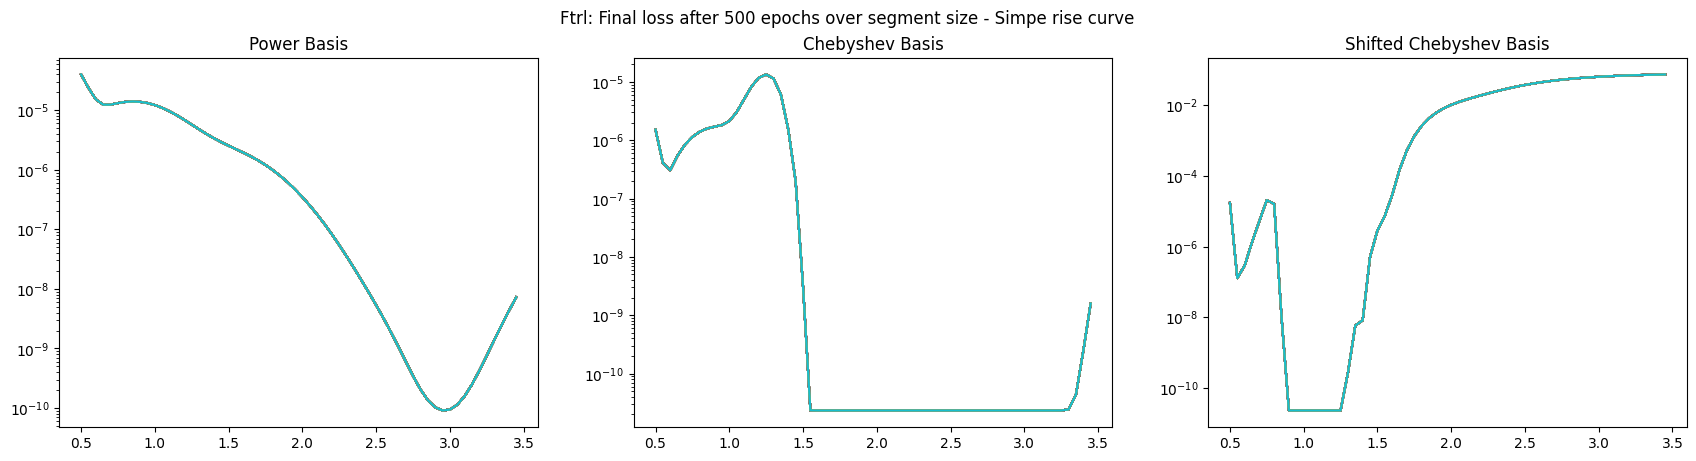

In [202]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("Ftrl: Final loss after 500 epochs over segment size - Simpe rise curve")

for i, b1 in enumerate(params):
    ax1.semilogy(params, [row[-1] for row in losses_simple_rise])
    ax2.semilogy(params, [row[-1] for row in losses_chebyshev_simple_rise])
    ax3.semilogy(params, [row[-1] for row in losses_shifted_chebyshev_simple_rise])
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")
ax3.set_title("Shifted Chebyshev Basis")

Text(0.5, 1.0, 'Shifted Chebyshev Basis')

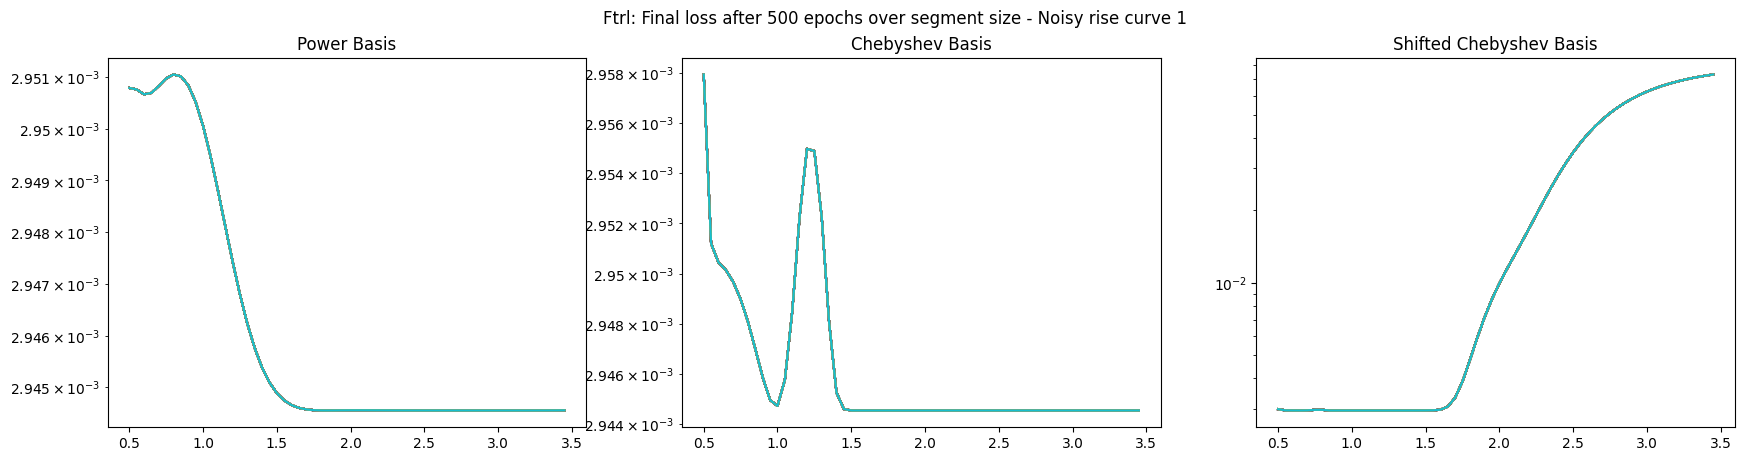

In [203]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("Ftrl: Final loss after 500 epochs over segment size - Noisy rise curve 1")

for i, b1 in enumerate(params):
    ax1.semilogy(params, [row[-1] for row in losses_noisy_rise_1])
    ax2.semilogy(params, [row[-1] for row in losses_chebyshev_noisy_rise_1])
    ax3.semilogy(params, [row[-1] for row in losses_shifted_chebyshev_noisy_rise_1])
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")
ax3.set_title("Shifted Chebyshev Basis")

Text(0.5, 1.0, 'Shifted Chebyshev Basis')

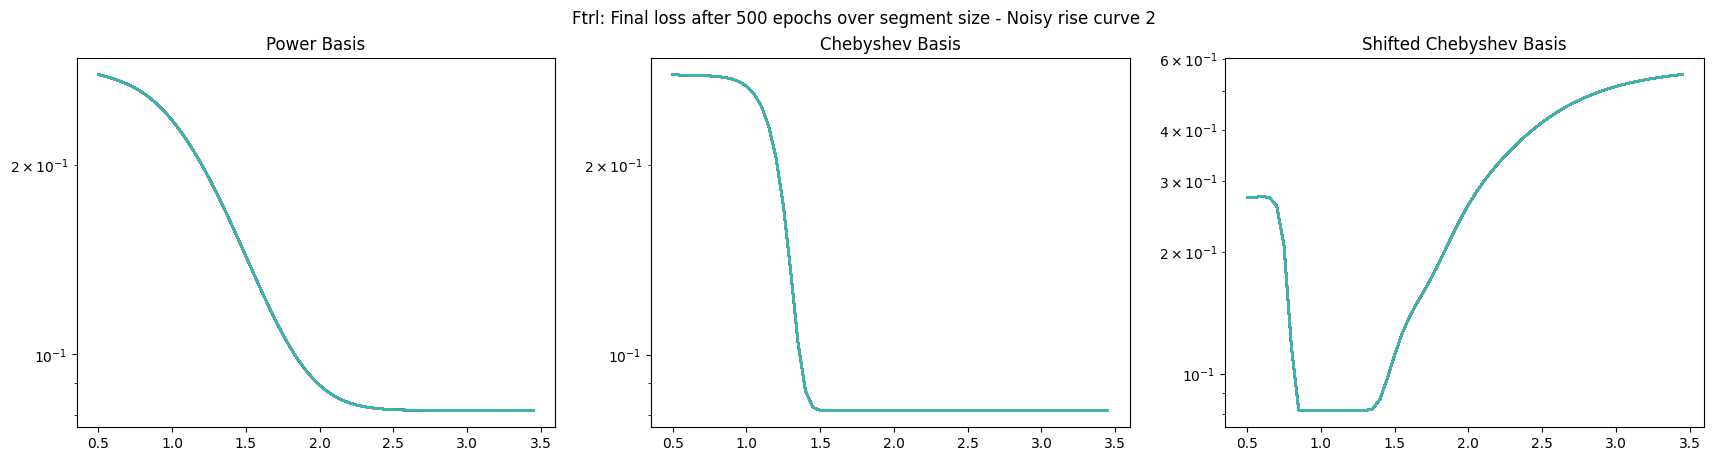

In [204]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("Ftrl: Final loss after 500 epochs over segment size - Noisy rise curve 2")

for i, b1 in enumerate(params):
    ax1.semilogy(params, [row[-1] for row in losses_noisy_rise_2], label='ygauss[2]')
    ax2.semilogy(params, [row[-1] for row in losses_chebyshev_noisy_rise_2], label='ygauss[2]')
    ax3.semilogy(params, [row[-1] for row in losses_shifted_chebyshev_noisy_rise_2], label='ygauss[2]')
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")
ax3.set_title("Shifted Chebyshev Basis")

### Interpretation

If the input data is noisy, the effect is not as high and bases are not as sensitive to data x range changes.

## Auto-rescale x-data

In [221]:
epochs = 500
no_segments = 4

In [222]:
spline_chebyshev_sine = model.Spline(polydegree=degree, polynum=no_segments, ck=ck, basis='chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_chebyshev_sine.fit(xsin, ysin, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, rescale_x_data=False)

<tf.Tensor: shape=(), dtype=float64, numpy=2.1329571132596012e-05>

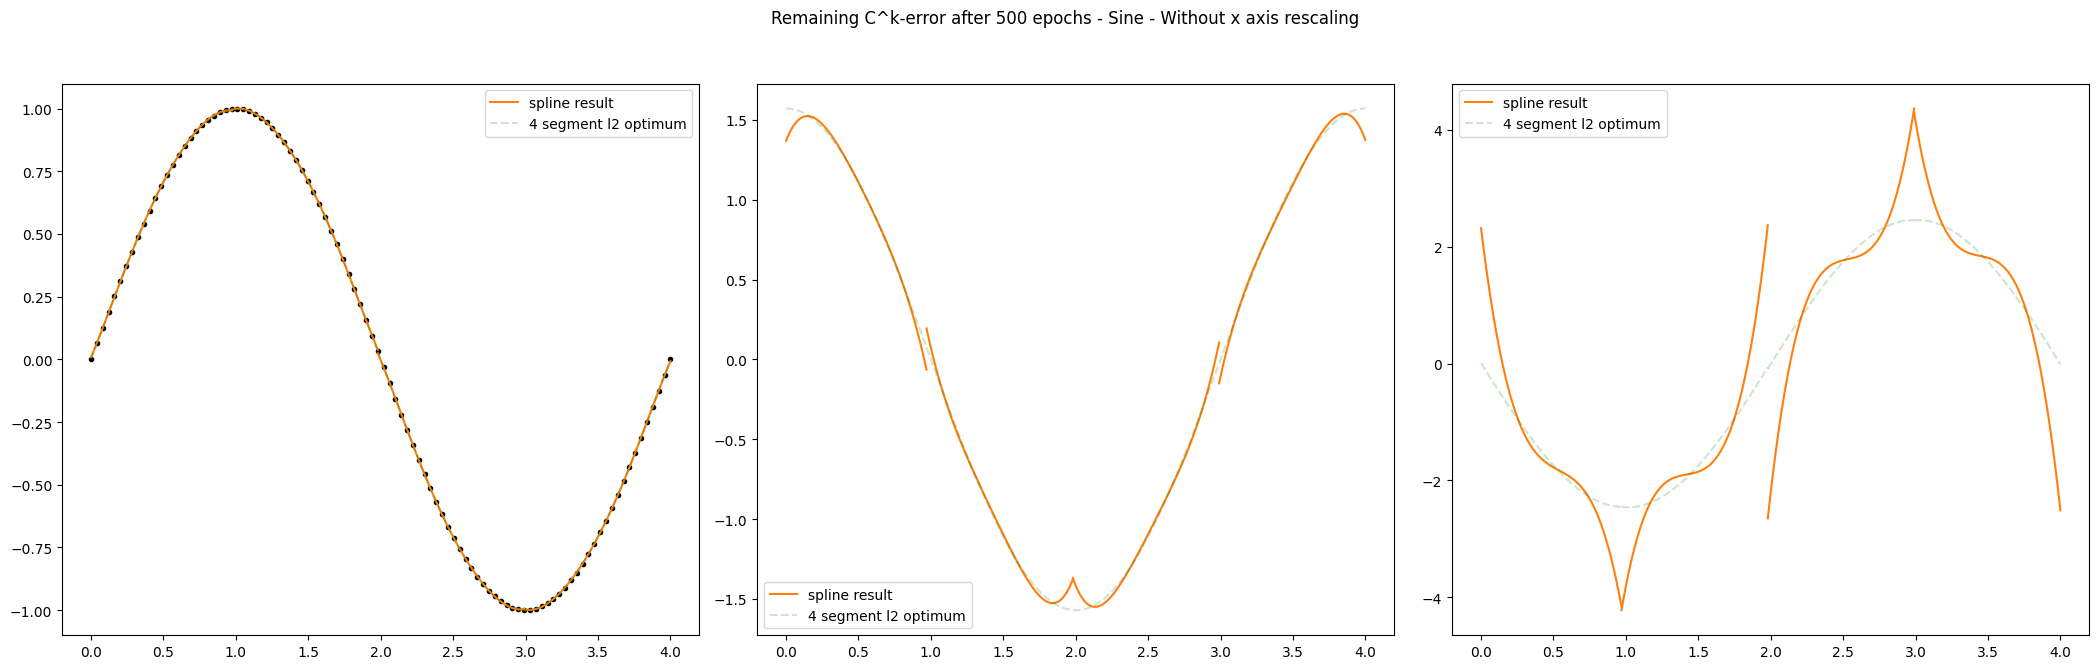

In [223]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Sine - Without x axis rescaling')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_sine, ax=axes[i], label=f'spline result', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_sine, ax=axes[i], deriv=i, color='g', label=f'{no_segments} segment l2 optimum')
    axes[i].legend(loc='best')

In [224]:
spline_chebyshev_sine = model.Spline(polydegree=degree, polynum=no_segments, ck=ck, basis='chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_chebyshev_sine.fit(xsin, ysin, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, rescale_x_data=True)

<tf.Tensor: shape=(), dtype=float64, numpy=1.1142844875880273e-10>

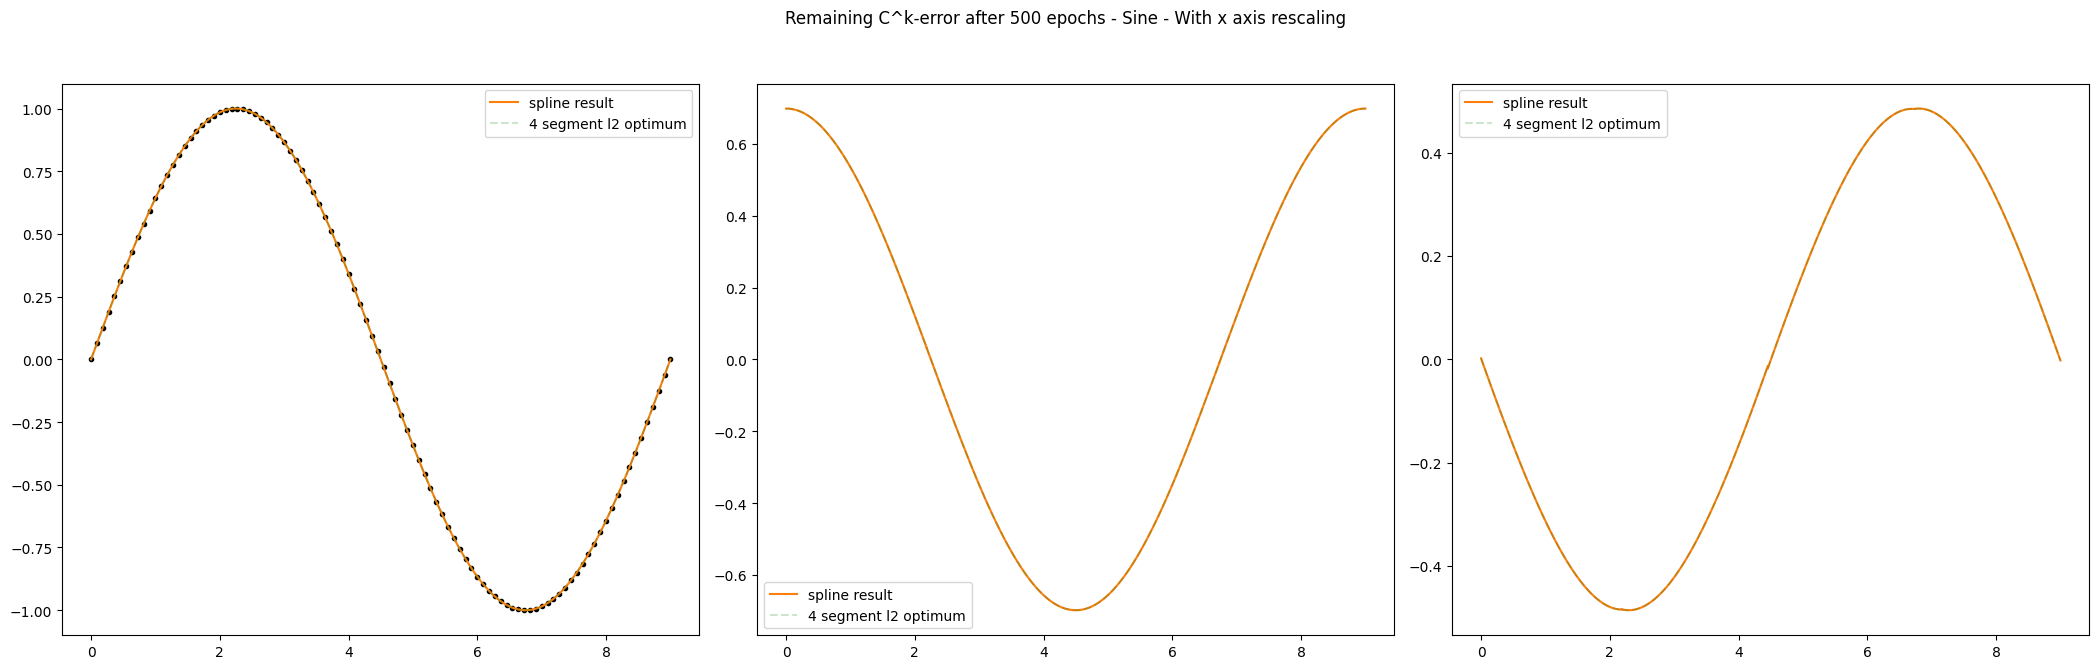

In [226]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Sine - With x axis rescaling')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_sine, ax=axes[i], label=f'spline result', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_sine, ax=axes[i], deriv=i, color='g', label=f'{no_segments} segment l2 optimum')
    axes[i].legend(loc='best')

In [227]:
spline_chebyshev_sine = model.Spline(polydegree=degree, polynum=no_segments, ck=ck, basis='shifted_chebyshev', continuity=False, shift_polynomial_centers=shift_polynomial_centers_sc)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_chebyshev_sine.fit(xsin, ysin, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, rescale_x_data=True)

<tf.Tensor: shape=(), dtype=float64, numpy=1.127810271281892e-10>

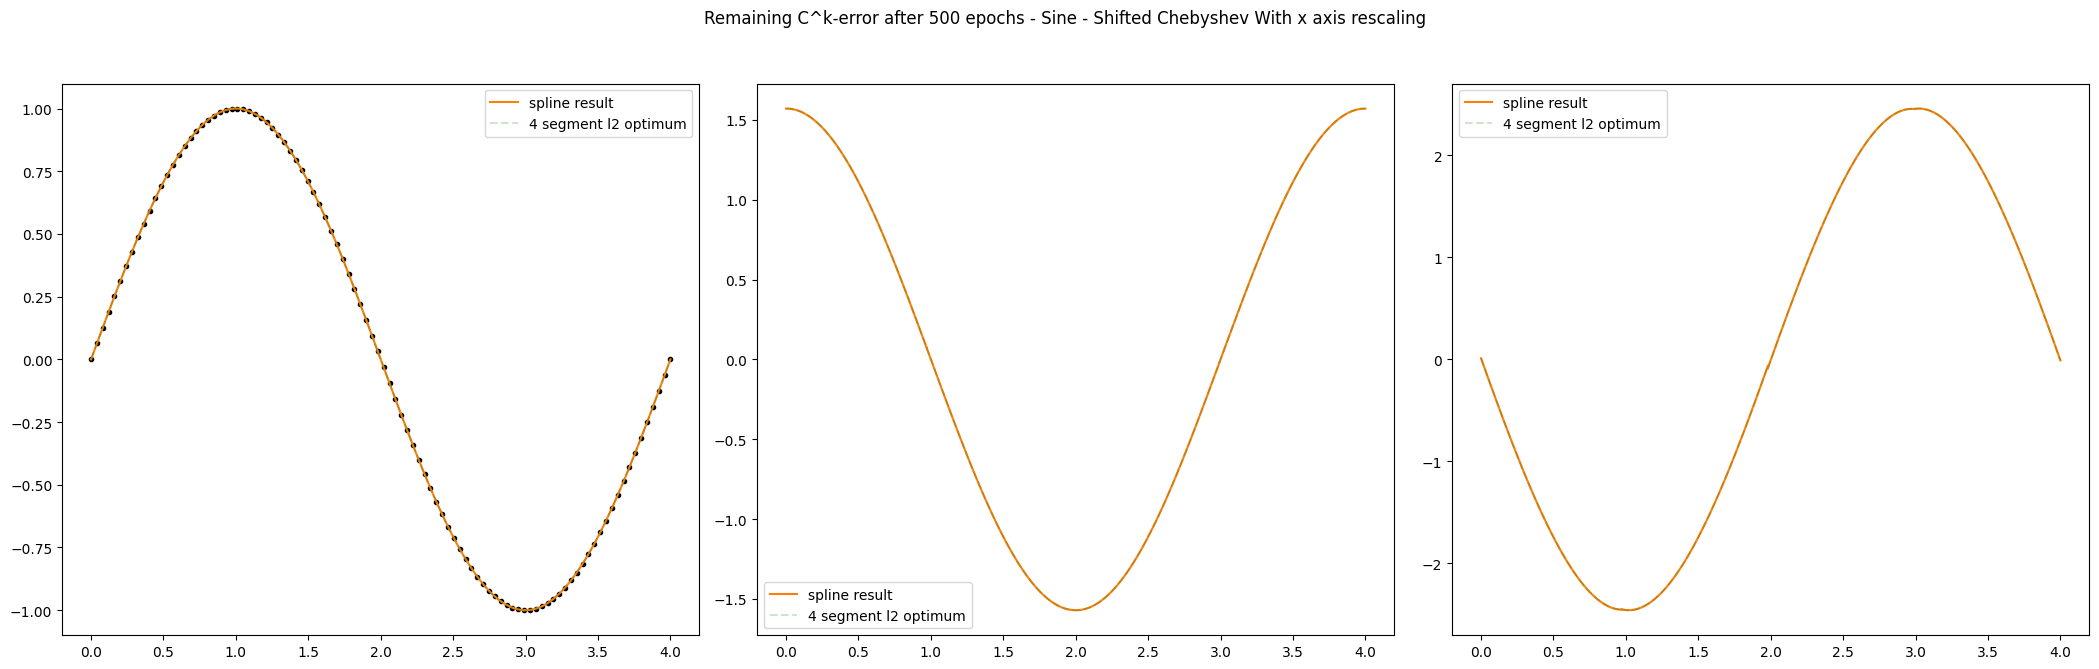

In [228]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Sine - Shifted Chebyshev With x axis rescaling')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_chebyshev_sine, ax=axes[i], label=f'spline result', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_chebyshev_sine, ax=axes[i], deriv=i, color='g', label=f'{no_segments} segment l2 optimum')
    axes[i].legend(loc='best')

In [231]:
spline_sine = model.Spline(polydegree=degree, polynum=no_segments, ck=ck, basis='power', continuity=False, shift_polynomial_centers=shift_polynomial_centers)
opt = keras.optimizers.Ftrl(learning_rate=learning_rate, learning_rate_power=-0.9)
spline_sine.fit(xsin, ysin, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, rescale_x_data=True)

<tf.Tensor: shape=(), dtype=float64, numpy=0.00014124017782970636>

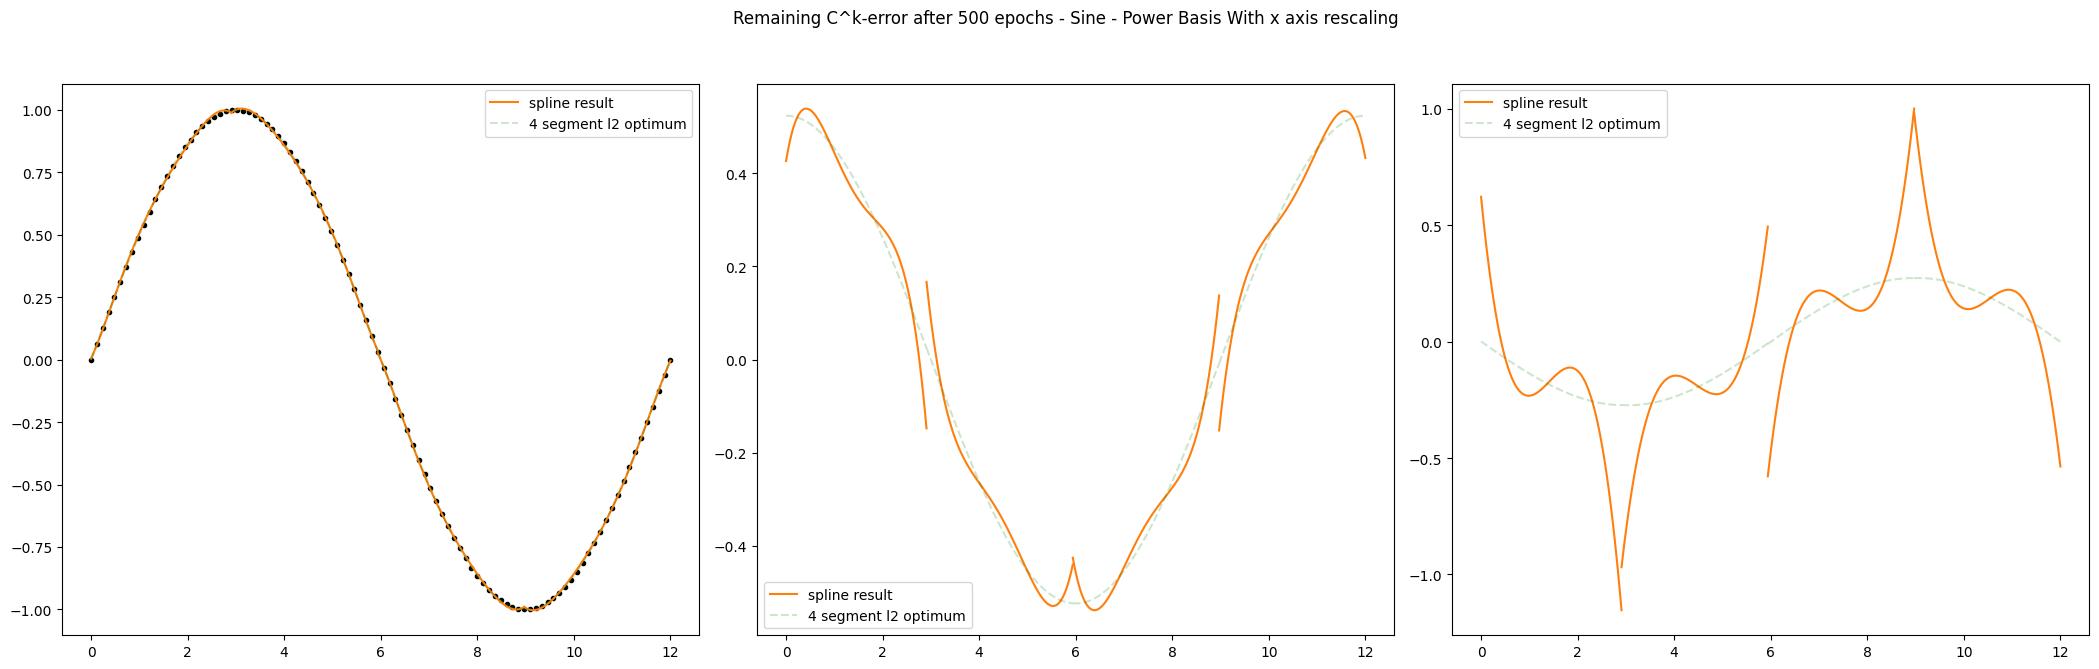

In [232]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining C^k-error after {epochs} epochs - Sine - Power Basis With x axis rescaling')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in range(0, 3):
    plot.plot_spline(spline_sine, ax=axes[i], label=f'spline result', segment_coloring=False, color=colors[1], deriv=i)
    plot.plot_l2optimum(spline_sine, ax=axes[i], deriv=i, color='g', label=f'{no_segments} segment l2 optimum')
    axes[i].legend(loc='best')